# Using the ml4qc package for a specific example analysis ("CAPI2")

This workbook demonstrates an example analysis for a particular CAPI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CAPI2".

This project is designed to explore the potential for ML-based tools to use only non-PII interview profiles (features constructed only from interview metadata and paradata) to identify outliers and submissions that are likely to be rejected by a human reviewer. It also explores use of ML techniques to explore interviewer effects.

In this case here, the survey team collected a wide range of metadata, and many submissions were reviewed.

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we use the [surveydata](https://surveydata.readthedocs.io/) package to load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **mean_light_level** - Mean light level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 3/4 of submissions are missing data for this field)
* **sd_light_level** - Standard deviation of light level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 3/4 of submissions are missing data for this field)
* **mean_movement** - Mean device movement during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 2/3 of submissions are missing data for this field)
* **sd_movement** - Standard deviation of device movement during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 2/3 of submissions are missing data for this field)
* **mean_movement** - Mean sound level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **sd_movement** - Standard deviation of sound level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **pct_quiet** - Percent of form-editing time when it was quiet ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **pct_still** - Percent of form-editing time when the device was still ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **duration** - Total number of seconds spent editing form
* **TA** - Name of text audit `.csv` file
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID
* **enumstr** - ID of enumerator who conducted the interview

In [2]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones
# (needed in this case because the storage and text audit formats used don't themselves include timezone info)
data_tz = pytz.timezone("Europe/Amsterdam").zone
collection_tz = pytz.timezone("Europe/Amsterdam").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab2/capi2/capi2.csv"), attachments_available=True)

# initialize location for outputs
output_path_prefix = "~/ml4qc-data/collab2/capi2/"

# initialize enumerator ID column name
enumerator_id_column = "enum"

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents (and handle mixed path separators in input file)
submissions_df['TA'] = submissions_df['TA'].apply(lambda path: path.replace('\\', os.sep).replace('/', os.sep))
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits in wide format
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text wide-format audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate        501
starttime             501
endtime               501
mean_light_level      309
sd_light_level        309
mean_movement         107
sd_movement           107
mean_sound_level      486
sd_sound_level        486
pct_quiet             486
pct_still             486
duration              501
TA                    501
review_quality        501
review_comments       501
review_corrections    501
review_status         501
review_quality1       501
review_quality2       501
review_quality3       501
reviewed              501
randomly_selected     501
n_flags               501
n_corr                501
enum                  501
device_info           501
missing_light         501
region_code           501
woreda_code           501
kebele_code           501
household_size        497
hhh_sex               497
a04_hh                501
household_size_hh     497
f_age                  16
m_age                  10
enumstr               501
dty

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for binary classification prediction using "submissions that are not APPROVED as GOOD quality" (i.e., rejected or another quality) as the target.

We use PCA to reduce our feature dimensions, targeting 99% variance retention. This allows ML model training and validation to be much faster. We also include the following controls for nonrandom assignment (so that it's the OLS residuals for each feature that are used for actual analysis):

* **region_code** - Region code
* **woreda_code** - Woreda code
* **kebele_code** - Kebele code
* **hhh_sex** - Sex of household head (from original sample)
* **household_size** - Household size (from original sample)

Since this is a static *ex post* dataset with all submissions already reviewed, we use 75% of the data for training and 25% for testing (our prediction set).

In [3]:
from ml4qc import SurveyMLClassifier

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.99

# random state for reproducible results (or None)
random_state = 411

analysis_df = all_data.drop(["SubmissionDate", "starttime", "endtime", "duration", "TA", "reviewed", "randomly_selected", "n_flags", "mean_movement", "sd_movement", "review_comments", "review_corrections", "review_quality1", "review_quality2", "review_quality3", "n_corr", "device_info", "mean_light_level", "sd_light_level", "missing_light", "enumstr", "a04_hh", "household_size_hh", "f_age", "m_age"], axis=1).copy(deep=True)
starting_n = len(analysis_df.index)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]
ending_n = len(analysis_df.index)
print(f"Dropped {starting_n-ending_n}/{starting_n} observations with missing data, for a loss of {((starting_n-ending_n)/starting_n)*100:.2f}%")
print()

# organize DataFrames with features and classes for prediction
class_columns = ["review_status", "review_quality", enumerator_id_column]
classes_df = analysis_df.loc[:, class_columns]
features_df = analysis_df.drop(class_columns, axis=1)

# set our target for prediction
target_description = "Not APPROVED+GOOD"
classes_df["target"] = classes_df.apply(lambda row: (0 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 1), axis=1)
target_df = pd.DataFrame(classes_df["target"])
print(f"Target description: {target_description}")
print(target_df.target.value_counts())
print()
print(f"Target base rate: {(len(target_df[target_df.target == 1])/len(target_df))*100:.2f}%")
print()

# create SurveyML object with 25% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=True, random_state=random_state, verbose=True, n_jobs=-3, calibration_method='isotonic', threshold="optimal_f", threshold_value=1, categorical_features=["enum", "review_quality", "review_status", "region_code", "woreda_code", "kebele_code", "hhh_sex"], control_features=["region_code", "woreda_code", "kebele_code", "hhh_sex", "household_size"])

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

Dropped 20/501 observations with missing data, for a loss of 3.99%

Target description: Not APPROVED+GOOD
1    285
0    196
Name: target, dtype: int64

Target base rate: 59.25%

numeric features: 29161
numeric controls: 1
numeric_binary features: 4664
numeric_binary controls: 0
numeric_unit_interval features: 24361
numeric_unit_interval controls: 0
numeric_other features: 136
numeric_other controls: 1
datetime features: 0
datetime controls: 0
other features: 2
other controls: 4
  Starting training set shape: (360, 29163)
Starting prediction set shape: (121, 29163)
  Training controls set shape: (360, 5)
Prediction controls set shape: (121, 5)
     Final training set shape: (360, 263)
   Final prediction set shape: (121, 263)
  Training controls set shape: (360, 105)
Prediction controls set shape: (121, 105)
         Training controls R2: max: 1.0; min: 0.06831933063352125; mean: 0.3686592383701323
  Prediction controls R2: max: 1.0; min: 0.18872350816010097; mean: 0.6988955460601938


## Performing analysis

In the cells that follow, we perform a series of analyses using the `scikit-learn` and `Tensorflow Keras` libraries, making use of the utilities available in the `SurveyMLClassifier` class. These models have not been extensively tuned, and they currently require re-tuning whenever the target or dimensionality-reduction settings change above.

### Identifying outliers

First, however, we use the `identify_outliers()` method available in the base `SurveyML` class, to identify outliers and save them to disk.

In [4]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

# identify outliers
x_outlier_df = surveyml.identify_outliers()

# save results to .csv
x_outlier_df.to_csv(os.path.expanduser(output_path_prefix + "ids_capi2_outlier_predictions.csv"))

# combine outlier prediction with target classification and show crosstab
x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

  Starting features shape: (481, 29163)
     Final features shape: (481, 29185)

Outliers: 0 (0.0%)
CPU times: user 1min 1s, sys: 1.2 s, total: 1min 2s
Wall time: 1min 2s


target,0,1
is_outlier,,
0,1.0,1.0


### Binary classification prediction with logistic regression

Here, we use logistic regression to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Logistic regression
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l


Best neg_brier_score: -0.2701803894658375
Parameters: {'C': 0.0001264961287093783, 'class_weight': None, 'penalty': 'l2'}

Running prediction model...

      Training set: (360, 263) (210 positive)
    Prediction set: (121, 263)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.3190766550522648

Fitting model...

Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


          Train accuracy:  58.33%
         Train precision:  58.33%
               Train F-1:  0.74
     Train ROC_AUC Score:  0.5
     Prediction accuracy:  61.98%
    Prediction precision:  61.98%
          Prediction F-1:  0.77
      Test ROC_AUC Score:  0.5


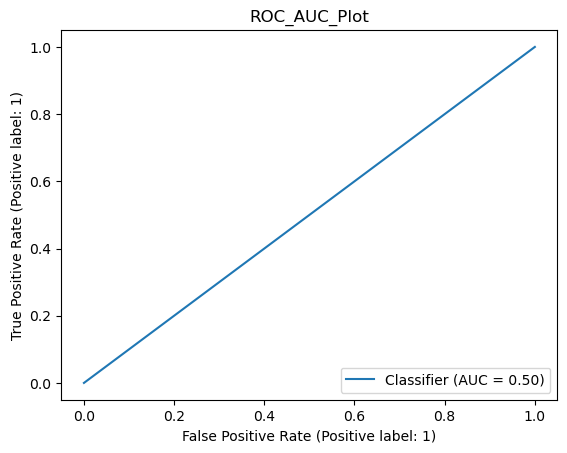

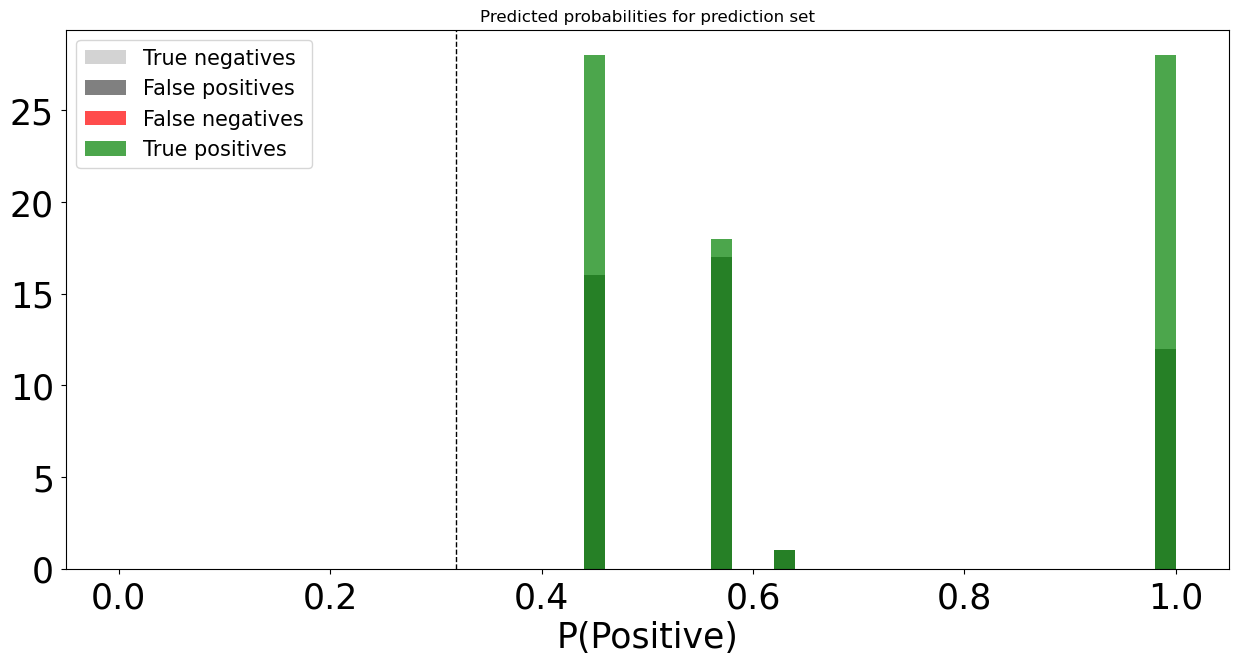

Test P(1) =  61.98%
Test P(1 | predicted 1) =  61.98%
Test P(1 | predicted 0) =  nan%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.62      1.00      0.77        75

    accuracy                           0.62       121
   macro avg       0.31      0.50      0.38       121
weighted avg       0.38      0.62      0.47       121



/Users/crobert/Code/Orange Chair Labs/ml4qc/src/ml4qc/surveymlclassifier.py:416: RuntimeWarning: invalid value encountered in long_scalars
  print("Test P(1 | predicted 0) = ", '{0:.2%}'.format(fn / (tn + fn)))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefi

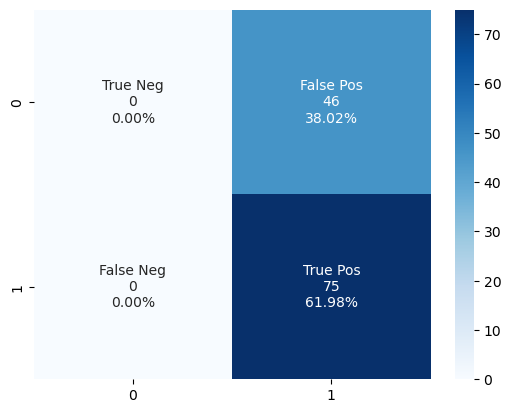

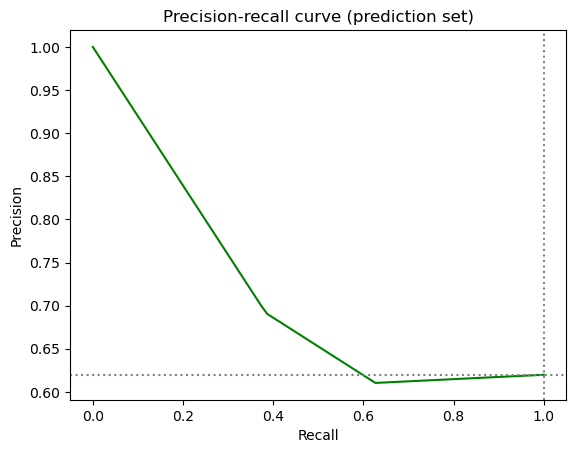

Cross validation results: 

fit_time: 0.026128705342610678 (SD: 0.0019188456224428865)
score_time: 0.0020981788635253905 (SD: 0.00012033351395422833)
test_accuracy: 0.5833333333333334 (SD: 0.0)
test_precision: 0.5833333333333334 (SD: 0.0)
test_f1: 0.7368421052631577 (SD: 1.1102230246251565e-16)
test_roc_auc: 0.48367724867724865 (SD: 0.032770463929862784)
test_neg_log_loss: -0.7823001449691335 (SD: 0.19480415883361596)
test_neg_brier_score: -0.24737674095138265 (SD: 0.004191688954430763)

Predictions made: 121
CPU times: user 853 ms, sys: 321 ms, total: 1.17 s
Wall time: 20.9 s


In [5]:
%%time

model_description = "Logistic regression"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.linear_model import LogisticRegression

# first use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_lr = LogisticRegression(random_state=random_state, max_iter=2000)
search_params = {'C': skl.utils.fixes.loguniform(0.0001, 100), 'penalty': ['l2'], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_lr, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=random_state, max_iter=10000, **params)
predictions = surveyml.run_prediction_model(classifier_lr)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.coef_[0])

### Binary classification prediction with a decision tree

Here, we use a decision tree to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Decision tree
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.26542075242476126
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 2, 'class_weight': None}

Running prediction model...

      Training set: (360, 263) (210 positive)
    Prediction set: (121, 263)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.5259253173147335

Fitting model...

Cross-validating model on training set...

          Train accuracy:  58.33%
         Train precision:  58.33%
               Train F-1:  0.74
     Train ROC_AUC Score:  0.5
     Prediction accuracy:  61.98%
    Prediction precision:  61.98%
          Prediction F-1:  0.77
      Test ROC_AUC Score:  0

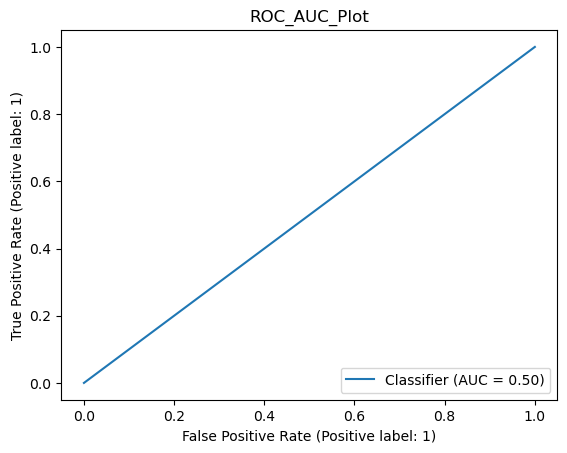

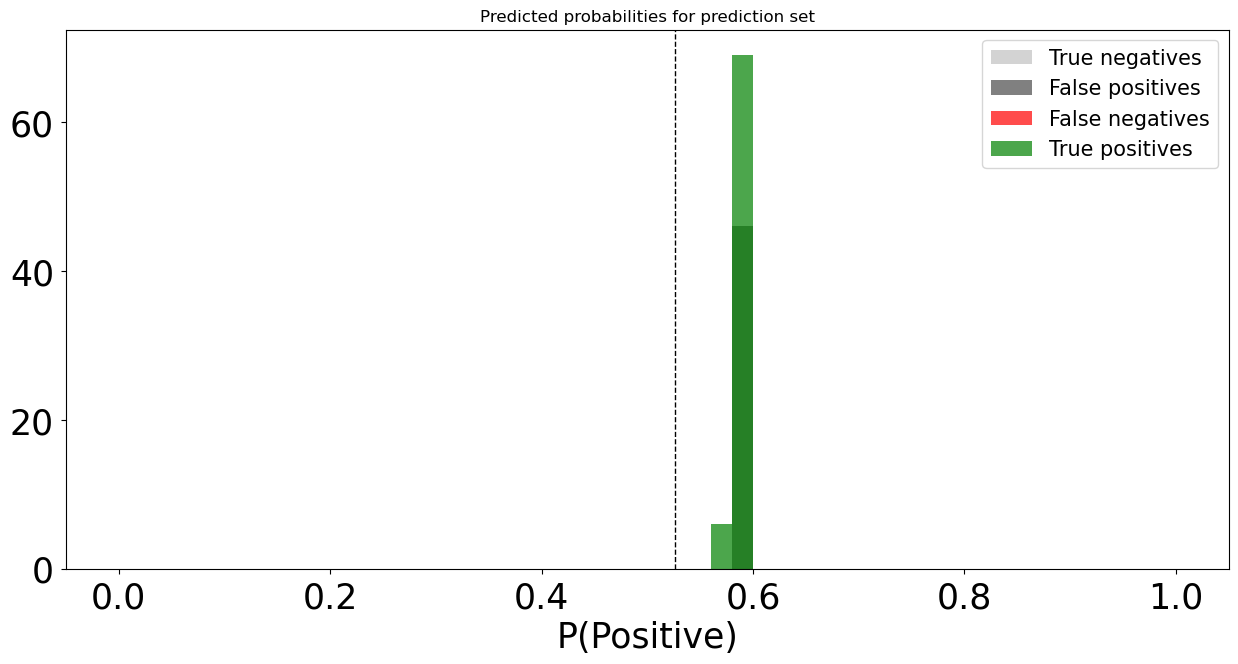

Test P(1) =  61.98%
Test P(1 | predicted 1) =  61.98%
Test P(1 | predicted 0) =  nan%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.62      1.00      0.77        75

    accuracy                           0.62       121
   macro avg       0.31      0.50      0.38       121
weighted avg       0.38      0.62      0.47       121



/Users/crobert/Code/Orange Chair Labs/ml4qc/src/ml4qc/surveymlclassifier.py:416: RuntimeWarning: invalid value encountered in long_scalars
  print("Test P(1 | predicted 0) = ", '{0:.2%}'.format(fn / (tn + fn)))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefi

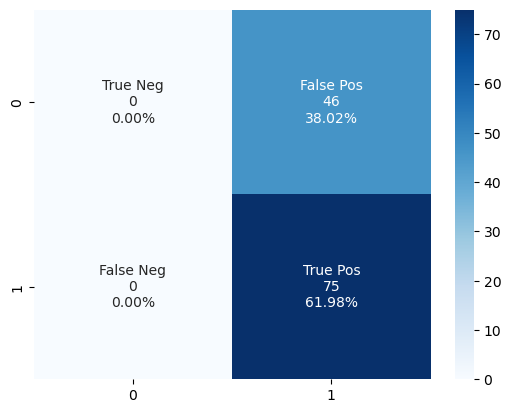

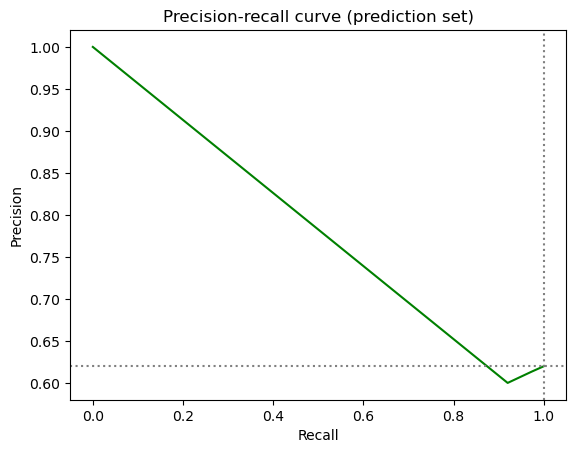

Cross validation results: 

fit_time: 0.008091290791829428 (SD: 0.00038863806767255583)
score_time: 0.0019090493520100911 (SD: 7.57430906222397e-05)
test_accuracy: 0.5814814814814814 (SD: 0.015101394842870455)
test_precision: 0.5835630115685823 (SD: 0.006799967795132414)
test_f1: 0.7329306056028871 (SD: 0.014516410900952587)
test_roc_auc: 0.4805026455026455 (SD: 0.037245783617764115)
test_neg_log_loss: -0.6831867256498364 (SD: 0.00820794343261112)
test_neg_brier_score: -0.24491342922281484 (SD: 0.003875363513250412)

Predictions made: 121
CPU times: user 663 ms, sys: 102 ms, total: 764 ms
Wall time: 2.1 s


In [6]:
%%time

model_description = "Decision tree"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.tree import DecisionTreeClassifier

# first use cross validation to find the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_dt, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state, **params)
predictions = surveyml.run_prediction_model(classifier_dt)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with random forest

Here, we use random forest to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Random forest
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.24687848721882863
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 2, 'class_weight': None, 'bootstrap': True}

Running prediction model...

      Training set: (360, 263) (210 positive)
    Prediction set: (121, 263)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.46045374084240037

Fitting model...

Cross-validating model on training set...

          Train accuracy:  63.89%
         Train precision:  61.76%
               Train F-1:  0.76
     Train ROC_AUC Score:  0.57
     Prediction accuracy:  61.98%
    Prediction precision:  61.98%
          Prediction F-1:  0.77
      Te

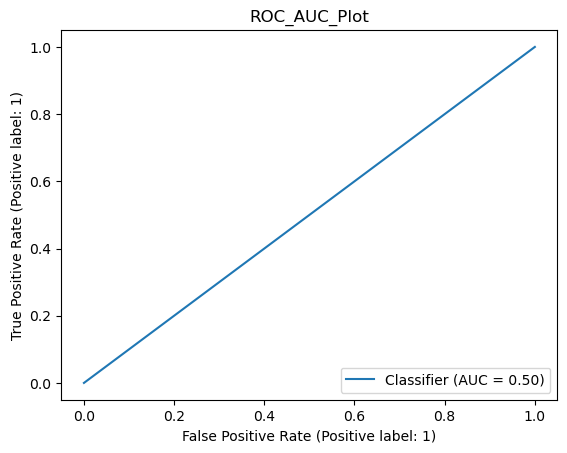

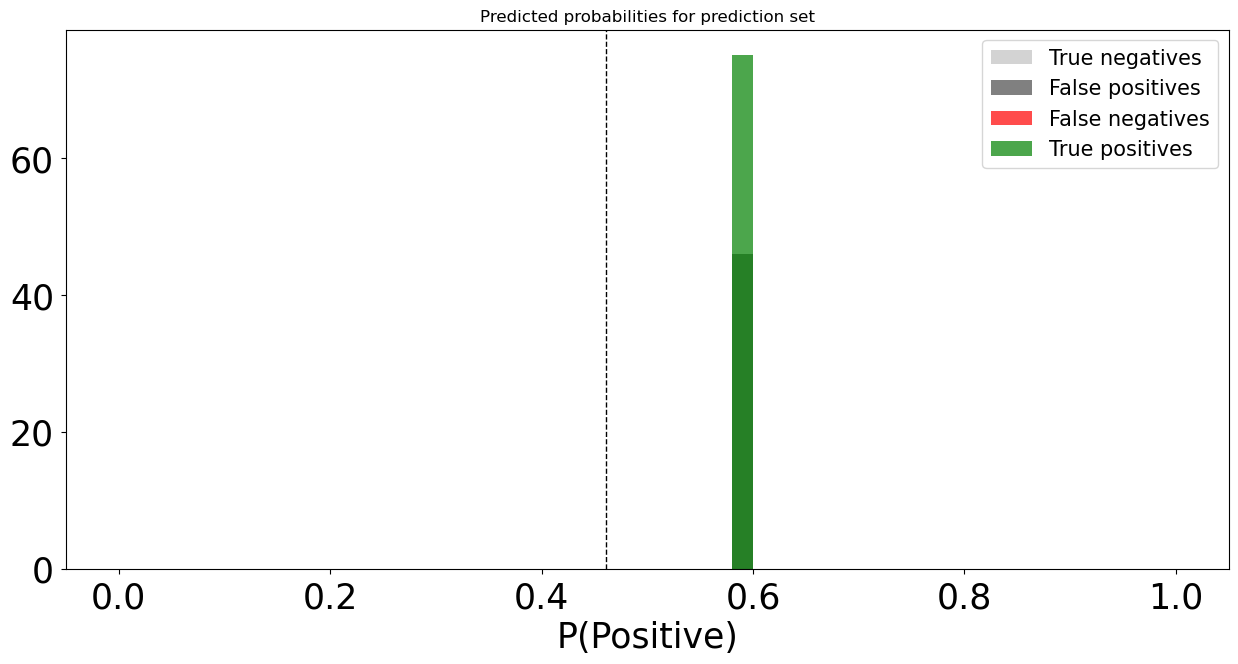

Test P(1) =  61.98%
Test P(1 | predicted 1) =  61.98%
Test P(1 | predicted 0) =  nan%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.62      1.00      0.77        75

    accuracy                           0.62       121
   macro avg       0.31      0.50      0.38       121
weighted avg       0.38      0.62      0.47       121



/Users/crobert/Code/Orange Chair Labs/ml4qc/src/ml4qc/surveymlclassifier.py:416: RuntimeWarning: invalid value encountered in long_scalars
  print("Test P(1 | predicted 0) = ", '{0:.2%}'.format(fn / (tn + fn)))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefi

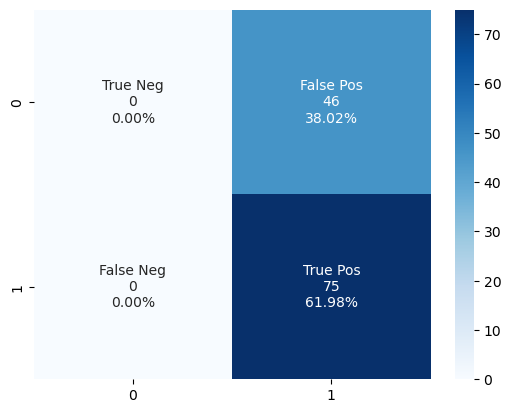

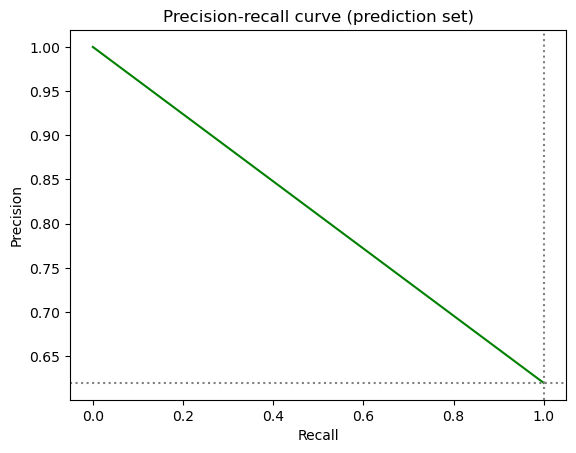

Cross validation results: 

fit_time: 2.630354722340902 (SD: 0.18320068834432776)
score_time: 0.04680824279785156 (SD: 0.004719464776188737)
test_accuracy: 0.5796296296296295 (SD: 0.010718367502583563)
test_precision: 0.581864153411347 (SD: 0.004191292716749963)
test_f1: 0.7334572527771485 (SD: 0.01006914227604083)
test_roc_auc: 0.4881216931216931 (SD: 0.021908915077993692)
test_neg_log_loss: -0.6813685127868278 (SD: 0.00394652815319448)
test_neg_brier_score: -0.24411136226472946 (SD: 0.0019244706134593282)

Predictions made: 121
CPU times: user 4.68 s, sys: 394 ms, total: 5.08 s
Wall time: 52.8 s


In [7]:
%%time

model_description = "Random forest"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.ensemble import RandomForestClassifier

# first use cross validation to find the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=50)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None], 'bootstrap': [True]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_rf, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_rf)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with XGBoost

Here, we use the XGBoost algorithm to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: XGBoost
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 54 candidates, totalling 810 fits


/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best neg_brier_score: -0.31201413070771583
Parameters: {'subsample': 1, 'scale_pos_weight': 1, 'min_child_weight': 1, 'max_depth': 2}

Running prediction model...

      Training set: (360, 263) (210 positive)
    Prediction set: (121, 263)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.35807689439971

Fitting model...

Cross-validating model on training set...

          Train accuracy:  61.94%
         Train precision:  60.52%
               Train F-1:  0.75
     Train ROC_AUC Score:  0.54
     Prediction accuracy:  61.98%
    Prediction precision:  61.98%
          Prediction F-1:  0.77
      Test ROC_AUC Score:  0.5


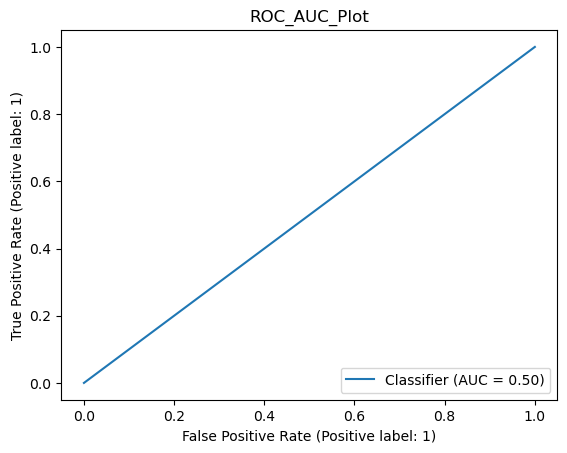

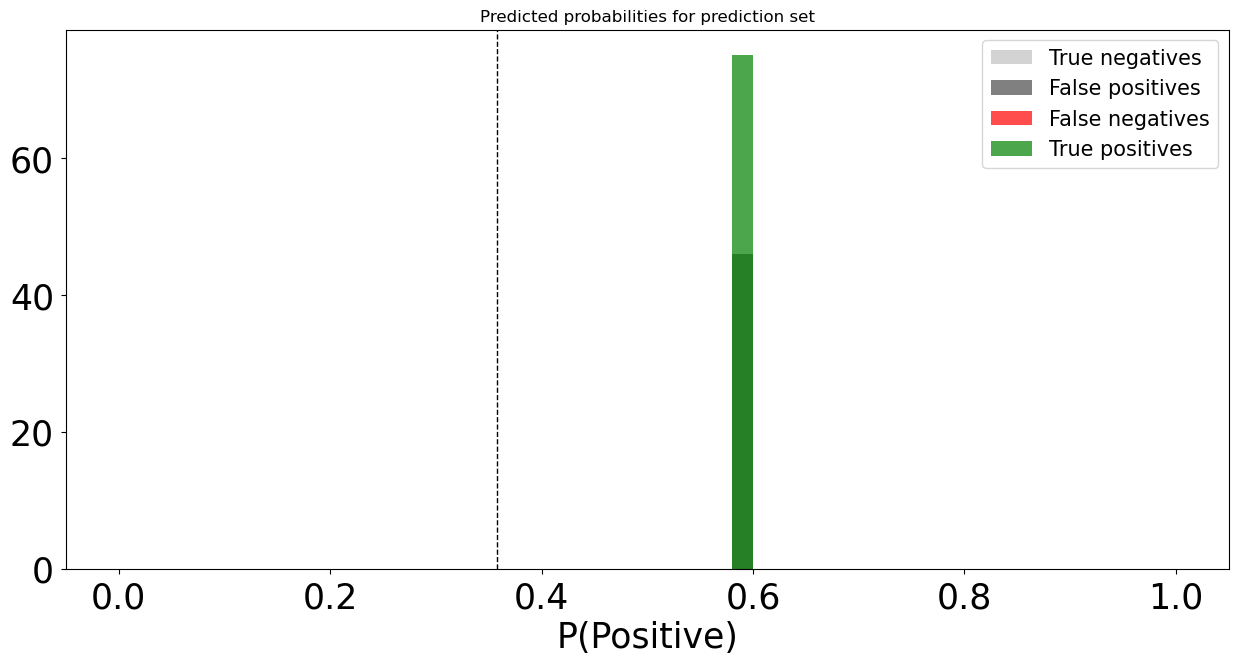

Test P(1) =  61.98%
Test P(1 | predicted 1) =  61.98%
Test P(1 | predicted 0) =  nan%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.62      1.00      0.77        75

    accuracy                           0.62       121
   macro avg       0.31      0.50      0.38       121
weighted avg       0.38      0.62      0.47       121



/Users/crobert/Code/Orange Chair Labs/ml4qc/src/ml4qc/surveymlclassifier.py:416: RuntimeWarning: invalid value encountered in long_scalars
  print("Test P(1 | predicted 0) = ", '{0:.2%}'.format(fn / (tn + fn)))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefi

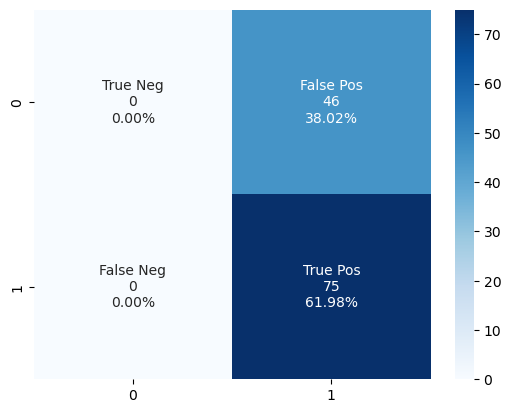

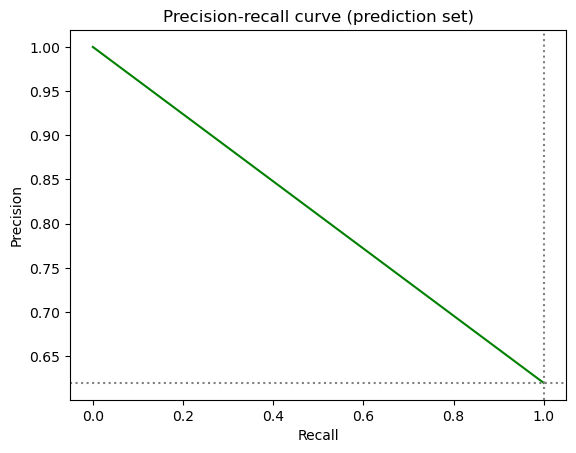

Cross validation results: 

fit_time: 2.6562849362691243 (SD: 0.4483912348253599)
score_time: 0.0038445631663004557 (SD: 0.00021334367083141286)
test_accuracy: 0.5833333333333334 (SD: 0.005071505162084874)
test_precision: 0.5834898278560251 (SD: 0.002602236173445361)
test_f1: 0.7365315944729077 (SD: 0.0033269604684934163)
test_roc_auc: 0.4774603174603174 (SD: 0.03993627871503265)
test_neg_log_loss: -0.877266644996904 (SD: 0.34316837570838193)
test_neg_brier_score: -0.24822645390835954 (SD: 0.006431533039058236)

Predictions made: 121
CPU times: user 6.97 s, sys: 2.81 s, total: 9.78 s
Wall time: 33.1 s


In [8]:
%%time

model_description = "XGBoost"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from xgboost import XGBClassifier

# first use cross validation to find the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=50)
search_params = {'max_depth': [2, 3, 4, 5, 7, 10], 'min_child_weight': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'scale_pos_weight': [1]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_xb, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_xb)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with a neural network

Here, we use a neural network to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Neural network
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


2023-06-07 15:25:25.365726: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-07 15:25:25.365781: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-07 15:25:25.365806: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-07 15:25:25.365993: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-07 15:25:25.367040: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-07 15:25:25.368246: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-07 15:25:25.368511: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-07 15:25:25.369356: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-07 15:27:20.943922: W tensorflow


Best neg_brier_score: -0.248330381066657
Parameters: {'batch_size': 32, 'class_weight': None, 'epochs': 10, 'model__activation': 'sigmoid', 'model__dropout_rate': 0.5, 'model__features': 263, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': 263, 'model__l2_factor': 0.0003799316823249954, 'model__l2_regularization': True, 'model__output_bias': None}

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_33 (Dropout)        (None, 263)               0         
                                                                 
 dense_33 (Dense)            (None, 263)               69432     
                                                                 
 dropout_34 (Dropout)        (None, 263)               0         
                                                                 
 dense_34 (Dense)            (None, 131)               34584  

          Train accuracy:  58.33%
         Train precision:  58.33%
               Train F-1:  0.74
     Train ROC_AUC Score:  0.5
     Prediction accuracy:  61.98%
    Prediction precision:  61.98%
          Prediction F-1:  0.77
      Test ROC_AUC Score:  0.5


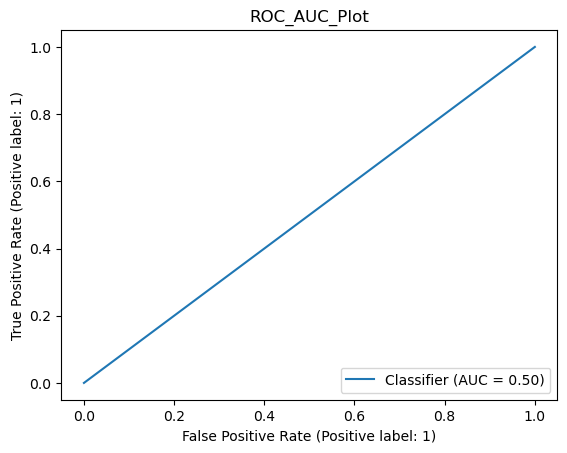

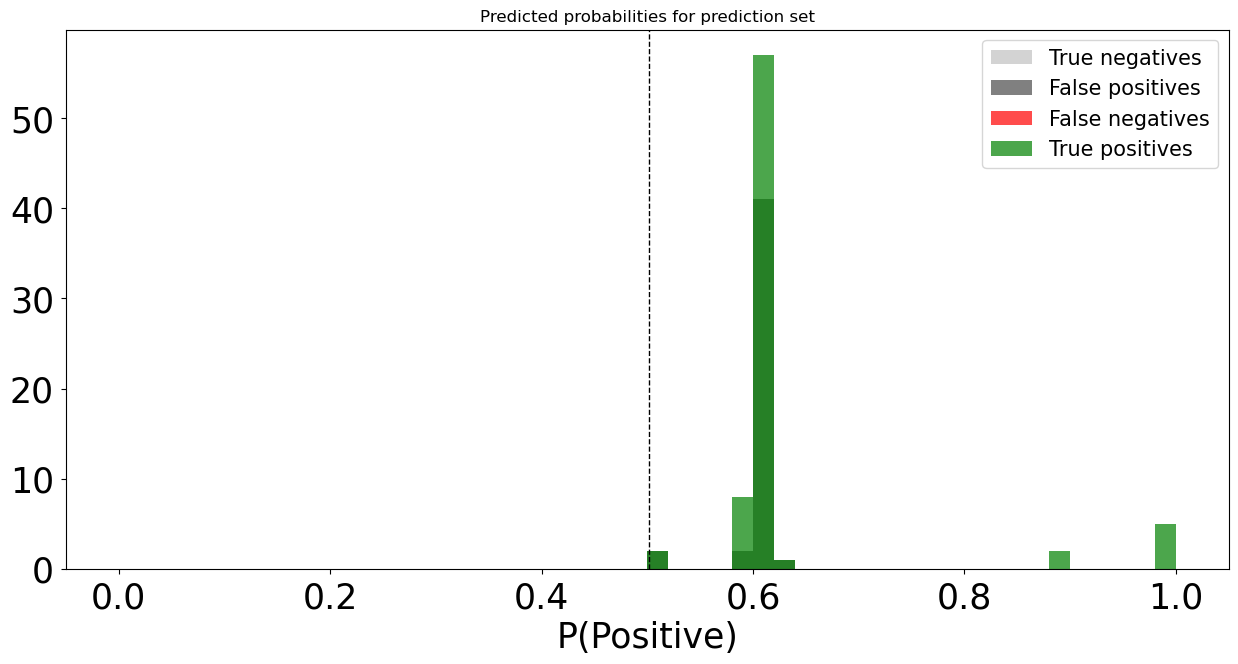

Test P(1) =  61.98%
Test P(1 | predicted 1) =  61.98%
Test P(1 | predicted 0) =  nan%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.62      1.00      0.77        75

    accuracy                           0.62       121
   macro avg       0.31      0.50      0.38       121
weighted avg       0.38      0.62      0.47       121



/Users/crobert/Code/Orange Chair Labs/ml4qc/src/ml4qc/surveymlclassifier.py:416: RuntimeWarning: invalid value encountered in long_scalars
  print("Test P(1 | predicted 0) = ", '{0:.2%}'.format(fn / (tn + fn)))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefi

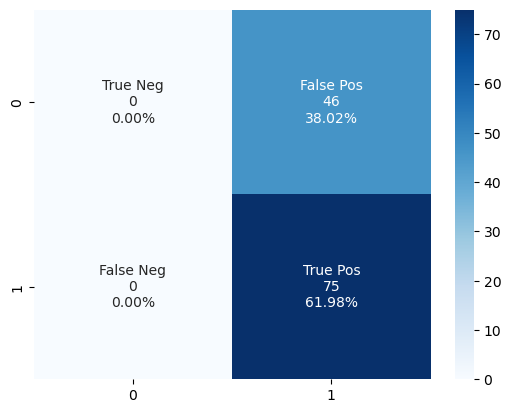

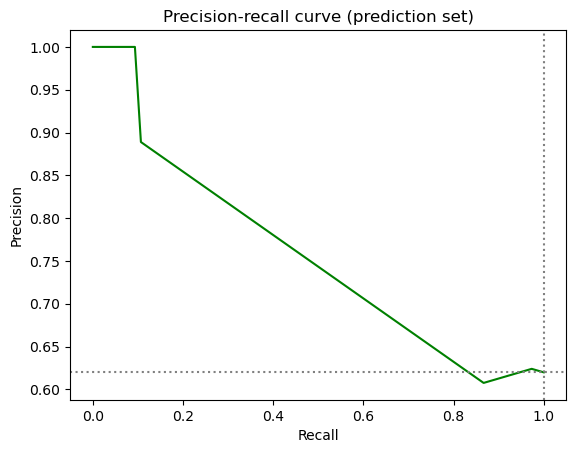

Cross validation results: 

fit_time: 4.576384019851685 (SD: 0.35670771897461834)
score_time: 0.10766382217407226 (SD: 0.01952328827941627)
test_accuracy: 0.5740740740740741 (SD: 0.016563466499998444)
test_precision: 0.5813053763428563 (SD: 0.00692572920136718)
test_f1: 0.7247782950484394 (SD: 0.01755566031594906)
test_roc_auc: 0.4722486772486772 (SD: 0.047803976598254055)
test_neg_log_loss: -0.7847031201837102 (SD: 0.19049774006509546)
test_neg_brier_score: -0.2487513509496497 (SD: 0.004928003346214004)

Predictions made: 121
CPU times: user 6.83 s, sys: 1.43 s, total: 8.26 s
Wall time: 4min 19s


In [14]:
%%time

model_description = "Neural network"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

import numpy as np
from scikeras.wrappers import KerasClassifier

# Option 1: use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0)
#   test initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
search_params = {'epochs': [10, 20, 40, 80, 100], 'batch_size': [16, 32], 'class_weight': [None], 'model__features': [surveyml.num_features], 'model__hidden_layers': [1, 2], 'model__initial_units': [surveyml.num_features, surveyml.num_features / 2], 'model__activation': ['relu', 'sigmoid'], 'model__l2_regularization': [True, False], 'model__l2_factor': skl.utils.fixes.loguniform(0.00001, 0.1), 'model__include_dropout': [True, False], 'model__dropout_rate': np.linspace(start=0.05, stop=0.5, num=10), 'model__output_bias': [None, np.log([surveyml.pos_train/surveyml.neg_train])]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_nn, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# Option 2: use results from an earlier CV search
# Best neg_brier_score: -0.03172571075887665
# Parameters: {'batch_size': 32, 'class_weight': None, 'epochs': 40, 'model__activation': 'relu', 'model__dropout_rate': 0.45, 'model__features': 665, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': 665, 'model__l2_factor': 0.0034877930278527348, 'model__l2_regularization': True, 'model__output_bias': None}
# params = {'batch_size': 32, 'class_weight': None, 'epochs': 40, 'model__activation': 'relu', 'model__dropout_rate': 0.45, 'model__features': surveyml.num_features, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': surveyml.num_features, 'model__l2_factor': 0.0034877930278527348, 'model__l2_regularization': True, 'model__output_bias': None}

# output summary of model
print(surveyml.build_nn_model(**{param[len("model__"):]:params[param] for param in params if param.startswith("model__")}).summary())
print()

# then fit the model using the optimal hyperparameters
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0, **params)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=True)
print()
print(f"Predictions made: {len(predictions)}")

### Enumerator analysis

The following analyses seek to take the interview profiles used for the analysis above, and consider empirical enumerator effects and relationships.

In [10]:
# summarize interview counts by enumerator ID
print(classes_df[enumerator_id_column].value_counts())

20    30
12    26
28    23
2     23
7     22
13    21
24    21
10    20
23    20
15    19
18    17
8     16
6     16
4     16
19    16
9     16
5     15
17    15
3     15
1     14
22    14
25    13
30    13
27    13
21    11
29    10
14     9
11     9
16     8
Name: enum, dtype: Int64


#### Cluster analysis

This first approach seeks to identify natural clusters of interview profiles, and tests to see whether clusters and enumerators are statistically independent. The clusters are saved to disk, and the p value is reported for a single chi-squared test of independence.

In [11]:
# identify clusters
clusters_df = surveyml.identify_clusters(min_clusters=2, max_clusters=10, separate_outliers=True, constrain_cluster_size=True)

# add enumerator ID's and save to disk
clusters_df[enumerator_id_column] = classes_df[enumerator_id_column]
clusters_df.to_csv(os.path.expanduser(output_path_prefix + "interview_clusters.csv"))

print()
print(f"Final clusters saved to disk:")
print(clusters_df.cluster.value_counts())
print()

# test for independence of cluster and enumerator
from scipy.stats import chi2_contingency
cluster_by_enum = pd.crosstab(clusters_df["cluster"], clusters_df[enumerator_id_column])
test_stat, pvalue, dof, expected_freq = chi2_contingency(cluster_by_enum)

print(f"p value for chi-squared against null that enumerator and cluster are unrelated: {pvalue}")

Identifying outliers...
  Starting features shape: (481, 29163)
     Final features shape: (481, 29185)

Outliers: 0 (0.0%)
0 outliers detected, will be put in separate cluster (-1).

  Starting features shape: (481, 29163)
     Final features shape: (481, 29185)

Choosing best silhouette coefficient for n_clusters between 2 and 10...

Silhouette coefficient for 2 clusters: 0.1655743814789861
1    361
0    120
Name: 0, dtype: int64

Silhouette coefficient for 3 clusters: 0.03854832423929055
1    320
0     81
2     80
Name: 0, dtype: int64

Silhouette coefficient for 4 clusters: -0.01078414041221684
2    240
1    121
3     60
0     60
Name: 0, dtype: int64

Silhouette coefficient for 5 clusters: -0.028742112441937934
4    189
1    100
2     94
0     50
3     48
Name: 0, dtype: int64

Silhouette coefficient for 6 clusters: -0.05462495658271343
4    152
3    133
0     76
1     40
2     40
5     40
Name: 0, dtype: int64

Silhouette coefficient for 7 clusters: -0.06883436523976116
4    137


#### Benchmarking against star enumerators

This next approach takes a list of known "star" enumerators (enumerators known to follow interview protocols and, in general, conduct excellent interviews) and benchmarks all interviews against those enumerators' interviews. A logistic regression classification approach is used to calculate the probability that each interview was conducted by a star enumerator. Each enumerator's average probability is then treated as a score and output to disk. Obviously, star enumerators will be scored most highly by construction.

Here, a powerful L2 regularization constant is used to generalize the model and provide for more variations in score.

In [12]:
# list star enumerators to benchmark against
star_enumerators = [3,8,19]

# benchmark against our star enumerators
benchmark_df = surveyml.benchmark_by_category(category_df=pd.DataFrame(classes_df[enumerator_id_column]), benchmark_categories=star_enumerators, method="logistic", reg_strength=0.001, variance_to_retain=1.0)

# save results to .csv
print(f"Benchmarking against the following enumerators saved to disk: {star_enumerators}")
benchmark_df.to_csv(os.path.expanduser(output_path_prefix + "enumerator_benchmarks.csv"))

0    434
1     47
Name: is_benchmark, dtype: int64

Target base rate: 9.77%

  Starting features shape: (481, 29163)
     Final features shape: (481, 29185)

Fitting model...

Benchmarking against the following enumerators saved to disk: [3, 8, 19]


#### Investigate enumerator similarities

This next approach uses a K-nearest-neighbor approach to predict which enumerator conducted each interview, based on which interview profiles are nearest, by weighted distance, to which others. The predictions are then summarized and output to disk, in crosstabs with count and row-wise-percentages, and in a high-level summary with the following columns:

* Enumerator ID [however it's named in source data]: the enumerator ID
* `self_similarity_score`: percentage of time an enumerator's interviews were correctly predicted to be conducted by them
* `most_like_self`: 1 for cases where the enumerator's interviews were most often classified as being conducted by them, otherwise 0
* `most_like`: most frequent enumerator predicted for the enumerator's interviews
* `most_like_score`: percentage of interviews predicted to be conducted by the "most_like" enumerator
* `second_most_like`: second-most-frequent enumerator predicted for the enumerator's interviews
* `second_most_like_score`: percentage of interviews predicted to be conducted by the "second_most_like" enumerator

If you randomly assign interviews to enumerators, you generally won't want to see strong enumerator effects. Ideally, you'd see low `self_similarity_score`s and "most_like" scores that suggest that it's hard to tell which enumerator conducted which interview. In fact, you'd ideally find interview profiles to be essentially random with respect to enumerator.

Finally, the p value for the chi-squared test of enumerator-predicted-enumerator independence is reported.

In [13]:
# predict the enumerator for each interview
enum_category_df = pd.DataFrame(classes_df[enumerator_id_column].astype('string'))
enum_df = surveyml.classify_by_category(category_df=enum_category_df, method="knn")

# test for independence of enumerator and predicted enumerator
from scipy.stats import chi2_contingency
enum_by_predicted = pd.crosstab(enum_df[enumerator_id_column], enum_df["predicted_category"])
enum_by_predicted_pct = pd.crosstab(enum_df[enumerator_id_column], enum_df["predicted_category"], normalize='index')
test_stat, pvalue, dof, expected_freq = chi2_contingency(enum_by_predicted)

print(f"p value for chi-squared against null that enumerator and predicted enumerator are unrelated: {pvalue}")
print()

# ensure all enumerators included in second dimension of crosstab, even if all 0's
for column in enum_by_predicted.index.values:
    if not column in enum_by_predicted.columns.values:
        enum_by_predicted[column] = 0
        enum_by_predicted_pct[column] = 0.0
enum_by_predicted = enum_by_predicted.reindex(sorted(enum_by_predicted.columns), axis=1)
enum_by_predicted_pct = enum_by_predicted_pct.reindex(sorted(enum_by_predicted_pct.columns), axis=1)

# create DataFrame with summary of empirical enumerator relationships
enum_relationship_df = pd.DataFrame(index=enum_by_predicted.index)
enum_relationship_df['most_like'] = enum_by_predicted_pct.columns[enum_by_predicted_pct.values.argsort(1)[:, -1]]
enum_relationship_df['second_most_like'] = enum_by_predicted_pct.columns[enum_by_predicted_pct.values.argsort(1)[:, -2]]
for index in enum_by_predicted_pct.index.values:
    enum_relationship_df.loc[index, "most_like_self"] = 1 if enum_relationship_df.loc[index, "most_like"] == index else 0
    enum_relationship_df.loc[index, "self_similarity_score"] = enum_by_predicted_pct.loc[index, index]
    enum_relationship_df.loc[index, "most_like_score"] = enum_by_predicted_pct.loc[index, enum_relationship_df.loc[index, "most_like"]]
    enum_relationship_df.loc[index, "second_most_like_score"] = enum_by_predicted_pct.loc[index, enum_relationship_df.loc[index, "second_most_like"]]
enum_relationship_df = enum_relationship_df[['self_similarity_score', 'most_like_self', 'most_like', 'most_like_score', 'second_most_like', 'second_most_like_score']]

# save results to .csv
print(f"Enumerator-predicted_enumerator crosstabs and enumerator relationships summary saved to disk")
enum_by_predicted.to_csv(os.path.expanduser(output_path_prefix + "enumerator_prediction_crosstab.csv"))
enum_by_predicted_pct.to_csv(os.path.expanduser(output_path_prefix + "enumerator_prediction_crosstab_pct.csv"))
enum_relationship_df.to_csv(os.path.expanduser(output_path_prefix + "enumerator_relationship_summary.csv"))

  Starting features shape: (481, 29163)
     Final features shape: (481, 29185)

Fitting model...

p value for chi-squared against null that enumerator and predicted enumerator are unrelated: 0.009605197499502617

Enumerator-predicted_enumerator crosstabs and enumerator relationships summary saved to disk
